 ## 02 - EDA on book genre

The following notebook will investigate the effect of book's characteristics
have on average daily sales. Eights features included in the dataset can be
broken down into 4 main groups:
1. price
2. ratings and reviews
3. publisher
4. genre

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from book_analysis.utils.visuals import *

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# paths for easy loading and saving
data_path = 'D:\\PycharmProjects\\springboard\\data'
image_path = 'D:\\PycharmProjects\\springboard\\book_analysis\\images'

# loading data
sales = pd.read_csv(f'{data_path}\\book_sales.csv', index_col=[0])

# Info on dataset
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27027 entries, 0 to 27026
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   genre                     27027 non-null  object 
 1   sold_by                   27027 non-null  object 
 2   daily_average_units_sold  27027 non-null  int64  
 3   publisher_name            27027 non-null  object 
 4   publisher_type            27027 non-null  object 
 5   average_rating            27027 non-null  float64
 6   sale_price                27027 non-null  float64
 7   total_reviews             27027 non-null  int64  
 8   price_range               27027 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 2.1+ MB


Pairplot gives a quick summary of how numerical variables interact here.

In [3]:
sales.describe()

,daily_average_units_sold,average_rating,sale_price,total_reviews
count,27027.000000,27027.000000,27027.000000,27027.000000
mean,29.614053,4.159787,6.777488,136.099345
std,157.739500,0.995815,6.368486,468.952999
min,1.000000,0.000000,0.010000,0.000000
25%,4.000000,4.080000,2.990000,12.000000
50%,9.000000,4.400000,5.120000,37.000000
75%,14.000000,4.640000,9.990000,111.000000
max,7000.000000,5.000000,141.520000,23362.000000


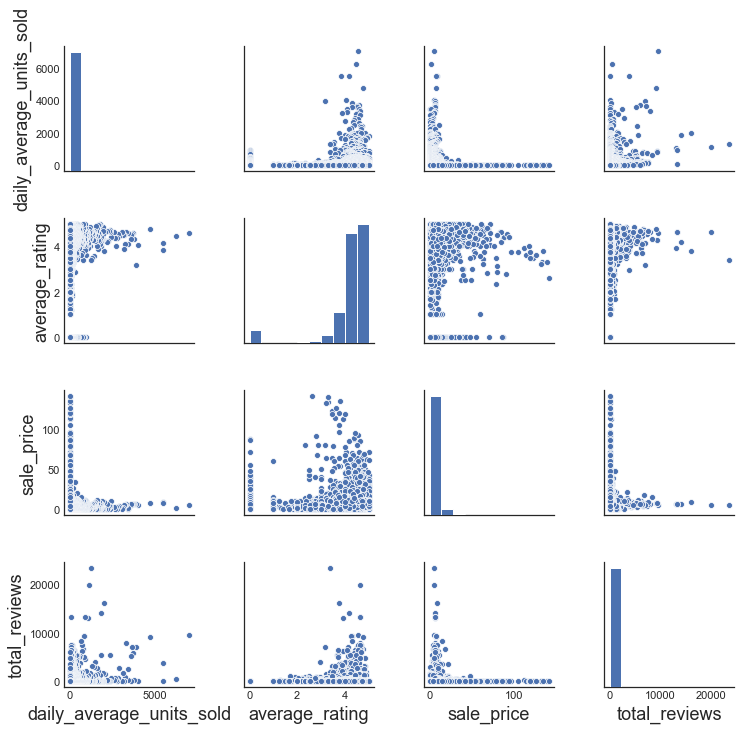

In [4]:
sns.pairplot(sales)

# 1. Price

First, lets see how much pricing effect the demand for books. Some insights:
1. sale_price has a large variance. Almost all books with price higher than $30
is non-fiction. One reason for this is non-fiction includes textbooks,
academic books, collections that are very expensive to produce with high markup.
2. Focusing in on the daily_sales vs. price plot. Surprisingly, there is a very
minor relationship between these two. (almost zero correlation)
3. Median price of 5.12 is very closed to average book price of 6.78. Over
75% of ebooks has the price tag under 10 dollars.

In [5]:
# which genre has such expensive prices
sales[sales.sale_price>30]['genre'].value_counts()

nonfiction       210
genre fiction      9
Name: genre, dtype: int64

In [6]:
# Median sale price
print('Median book price:', sales.sale_price.median())
print('Mean book price:', sales.sale_price.mean())

Median book price: 5.12
Mean book price: 6.777487697487698


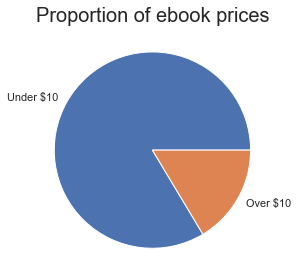

In [7]:
# Number of book price under 10 dollars
under_10 = sum([True for x in sales.sale_price if x < 10])
over_10 = len(sales) - under_10

# pie plot of proportion of book prices
df = pd.DataFrame({'n':[under_10, over_10]},
                  index=['under 10', 'over 10'])
df.plot.pie(y='n', labels=['Under $10', 'Over $10'])

# plot parameters
plt.ylabel('')
plt.title('Proportion of ebook prices')
plt.tight_layout()
plt.gca().get_legend().remove()
plt.savefig(f'{image_path}\\proportion_book_under10.png')

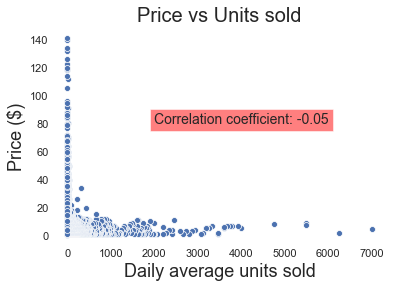

In [8]:
# sale_price vs daily_average_unit_sold for books that sale over 1000 copies
sns.scatterplot(y='sale_price',
                x='daily_average_units_sold',
                data=sales)

# correlation
corr = np.corrcoef(sales.daily_average_units_sold, sales.sale_price)
text = f'Correlation coefficient: {np.round(corr[0,1],2)}'

# plot parameters
plt.xlabel('Daily average units sold')
plt.ylabel('Price ($)')
plt.title('Price vs Units sold')
sns.despine(left='True', bottom='True')
plt.text(x=2000,
         y=80,
         s=text,
         fontsize=14,
         bbox=dict(facecolor='red', alpha=0.5))
plt.savefig(f'{image_path}\\price_unit_sold_correlation.png')

Before moving on to ratings and reviews, lets see how different publisher type
set their prices. Since the variance in price is large, y scale is transformed
with log(x+1) scale. (price below 1 gives negative values).

All books with price below 1 dollar are from by small/medium publishers.
Titles published by big five has the highest median price.

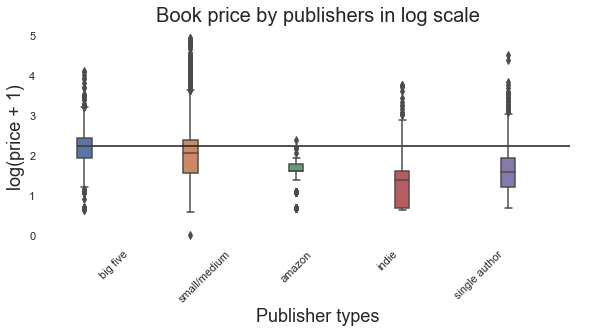

In [70]:
# price scatter with publisher
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(ax=ax,
            x='publisher_type',
            y=np.log(sales.sale_price + 1),
            hue='publisher_type',
            data=sales,)

# big give median for comparison
big_five_median = sales[sales.publisher_type=='big five'].sale_price.median()

# plot parameters
plt.title('Book price by publishers in log scale')
plt.xlabel('Publisher types')
plt.xticks(rotation=45)
plt.ylabel('log(price + 1)')
plt.hlines(y=np.log(big_five_median+1),xmin=-.4,xmax=5)
sns.despine(left=True, bottom=True)
plt.gca().get_legend().remove()

plt.savefig(f'{image_path}\\price_publisher_type.png')

# 2. Ratings and reviews

average ratings + distribution, sales, publishers, total_reviews,
zero rating books.


total reviews _ distribution, sales

0        9604
1         450
2          30
3        3747
4        9174
         ... 
27022       8
27023      35
27024       0
27025       7
27026       8
Name: total_reviews, Length: 27027, dtype: int64

# 3. Publishers

publisher type + sales/number of titles in 1 plot, median price is mentioned above

some trivia: top 10 publisher has the most books/ most sales.

TypeError: savefig() missing 1 required positional argument: 'fname'

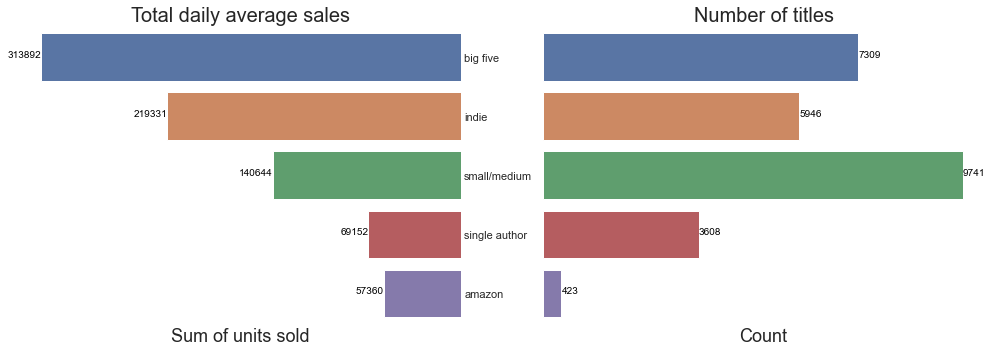

In [127]:
# set up plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# create total daily sales data by publishers
df = sales.groupby('publisher_type')['daily_average_units_sold'].sum().reset_index()
df = df.sort_values('daily_average_units_sold', ascending=False)

# Left plot with book count by publisher type
sns.barplot(y='publisher_type',
            x='daily_average_units_sold',
            data=df,
            ax=ax1)

# Left plot parameters
ax1.invert_xaxis()
ax1.set_title('Total daily average sales')
ax1.set_xlabel('Sum of units sold')
ax1.yaxis.tick_right()
ax1.set_ylabel('')
ax1.set_xticks([])
sns.despine(ax=ax1, left=True, bottom=True)

# Adding text to left plot
df.index = np.arange(0,5)
for index, row in df.iterrows():
    ax1.text(row.daily_average_units_sold,
             row.name,
             row.daily_average_units_sold,
             color='black',
             ha='right')

# create total book count data by publishers
df2 = sales.groupby('publisher_type')['daily_average_units_sold'].count().reset_index()

# sorting the right order for nicer plot
publisher_list = list(df.publisher_type)
mapping = {publisher: i for i, publisher in enumerate(publisher_list)}
key = df2['publisher_type'].map(mapping)
df2 = df2.iloc[key.argsort()]

# Right plot with book daily sales by publisher type
sns.barplot(y='publisher_type',
            x='daily_average_units_sold',
            data=df2,
            ax=ax2)

# right plot parameters
ax2.set_title('Number of titles')
ax2.set_ylabel('')
ax2.set_xlabel('Count')
ax2.set_xticks([])
sns.despine(ax=ax2, left=True, bottom=True)

# adding text and remove axis
df2.index = np.arange(0,5)
for index, row in df2.iterrows():
    ax2.text(row.daily_average_units_sold,
             row.name,
             row.daily_average_units_sold,
             color='black',
             ha='left')

# Plot parameteres
fig.tight_layout()
fig.savefig()

# 4. Genre

Lets take a quick look at the distribution of ebook titles and daily sales
broken down with genre.
Some observations:
* non-fiction and genre fiction dominates the market in both number of titles and
sales. Only these two have multiple titles that sales on average 1000+ copy daily.
* Trying to be popular in niche genre such as children (Dr.Seuss) and comics (Stan Lee)
 is much harder compared to other genres.

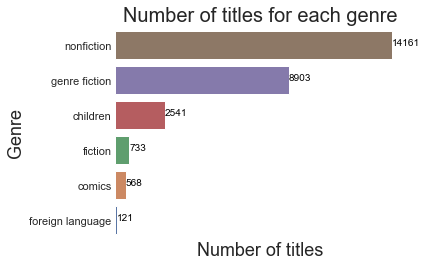

In [9]:
# Group books by genre and count number of book in each genre
df = sales.groupby('genre')['daily_average_units_sold'].count().reset_index()
df = df.sort_values('daily_average_units_sold', ascending=False)

# plot
g = sns.barplot(x='daily_average_units_sold',
                y='genre',
                hue='daily_average_units_sold',
                dodge=False,
                data=df)

# insert numbers beside the bars
df.index = np.arange(0,6)
for index, row in df.iterrows():
    g.text(row.daily_average_units_sold, row.name, row.daily_average_units_sold, color='black', ha='left')

# plot parameters
sns.despine(left=True, bottom=True)
plt.xlabel('Number of titles')
plt.ylabel('Genre')
plt.title('Number of titles for each genre')
plt.tight_layout()
plt.gca().get_legend().remove()
plt.xticks([])

# save figures
plt.savefig(f'{image_path}\\number_titles_genre.png')

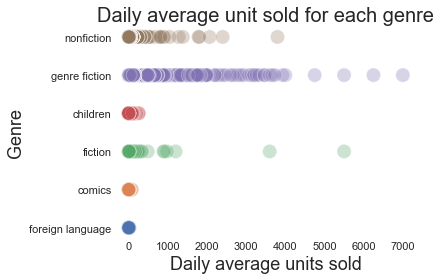

In [10]:
# copy df as sales
df = sales

# Sorting the right order
genre_list = ['foreign language', 'comics', 'fiction', 'children', 'genre fiction', 'nonfiction']
mapping = {genre: i for i, genre in enumerate(genre_list)}
key = df['genre'].map(mapping)

# sort order of genre based on the list
df = df.iloc[key.argsort()]

# Daily unit sold of books broken down by genre
sns.scatterplot(y='genre', x='daily_average_units_sold',
                hue='genre',
                s=200,
                alpha=0.3,
                data=df)

# Adjusting plot parameters
sns.despine(left=True, bottom=True)
plt.xlabel('Daily average units sold')
plt.ylabel('Genre')
plt.title('Daily average unit sold for each genre')
plt.tight_layout()
plt.gca().get_legend().remove()

plt.savefig(f'{image_path}\\genre_unit_sold.png')

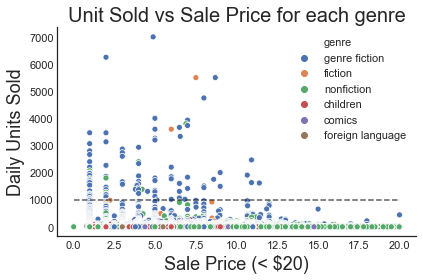

In [13]:
sns.scatterplot(x='sale_price', y='daily_average_units_sold', 
                data=sales[sales.sale_price < 20], hue='genre')
plt.hlines(y=1000, xmin=0, xmax=20, linestyles='--', alpha=0.7)
plt.xlabel('Sale Price (< $20)')
plt.ylabel('Daily Units Sold')
plt.title('Unit Sold vs Sale Price for each genre')
plt.tight_layout()

plt.savefig(f'{image_path}\\genre_unit_price20.png')
